# DCT-Domain Subsampling

In this notebook, we examine how to subsample an image while in the DCT domain. DCT-domain subsampling is crucial to DCT-domain Chroma from Luma (CfL) because of [Chroma subsampling](https://en.wikipedia.org/wiki/Chroma_subsampling).

When the 4:2:0 Chroma subsampling is used, the Chroma prediction needs to be subsample to match the chroma subsampling.

## Loading y4m

For this experiement, we will use a 4:2:0 Y4M file. You can create a 420 y4m file using ffmpeg with the following command

```
ffmpeg -i Owl.jpg -pix_fmt yuv420p owl.y4m
```

Next, we load the image using the y4m package. It might not be apparent, but the Luma plane is twice the size of the Chroma planes.

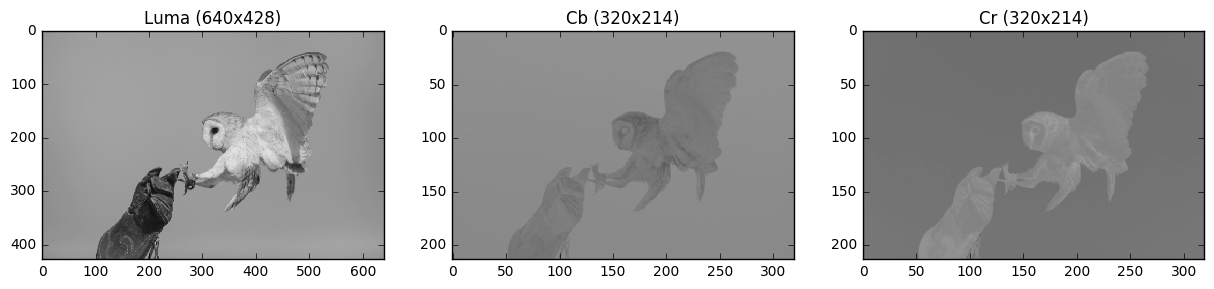

In [14]:
%matplotlib inline

import sys
import y4m
import matplotlib.pyplot as plt
import numpy as np

def decode_y4m_buffer(frame):
    W, H = frame.headers['W'], frame.headers['H']
    Wdiv2, Hdiv2 = W // 2, H // 2
    C, buf = frame.headers['C'], frame.buffer
    A, Adiv2, div2 = W * H, Hdiv2 * Wdiv2, (Hdiv2, Wdiv2)
    dtype, scale = 'uint8', 1.
    if C.endswith('p10'):
        dtype, scale, A = 'uint16', 4., A * 2
    Y = (np.ndarray((H, W), dtype, buf))
    Cb = (np.ndarray(div2, dtype, buf, A))
    Cr = (np.ndarray(div2, dtype, buf, A + Adiv2))
    return Y, Cb, Cr
def process():
   pass 

def y4mread(file):
    parser = y4m.Reader(process(), verbose=True)
    frame = None
    with open(file, 'rb') as f:
        while True:
            data = f.read(2048)
            if not data:
                break
            parser._data += data
            if parser._stream_headers is None:
                parser._decode_stream_headers()            
            if frame is None:
                frame = parser._decode_frame()
            else :
                break
    Y, Cb, Cr = decode_y4m_buffer(frame)
    return Y, Cb, Cr

Y, Cb, Cr = y4mread("images/owl.y4m")

plt.figure(figsize=(15,10))


y_height, y_width = Y.shape
cb_height, cb_width = Cb.shape
cr_height, cr_width = Cr.shape

plt.subplot(1,3,1)

plt.title("Luma (%dx%d)" % (y_width, y_height))
plt.imshow(Y, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255, aspect='equal', interpolation='nearest');
plt.subplot(1,3,2)
plt.title("Cb (%dx%d)" % (cb_width, cb_height))
plt.imshow(Cb, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255, aspect='equal', interpolation='nearest');
plt.subplot(1,3,3)
plt.title("Cr (%dx%d)" % (cr_width, cr_height))
plt.imshow(Cr, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255, aspect='equal', interpolation='nearest');

## The DCT Domain
Let's  convert the luma plane of our image to the DCT domain. To do so, we will use 8x8 blocks and the [normalized DCT-II](https://en.wikipedia.org/wiki/Discrete_cosine_transform#DCT-II):

### DCT-II
$$X_k = \sum_{n=0}^{N-1} x_n \cos \left( \frac{\pi}{N} \left( n + \frac{1}{2} \right)k \right) \quad k = 0,\ldots,N-1$$

### Normalization
$$X_0 = X_0 \times \frac{1}{\sqrt{2}}$$
$$X_k = X_k \times \sqrt{\frac{2}{N}} \quad k=0,\ldots,N-1$$

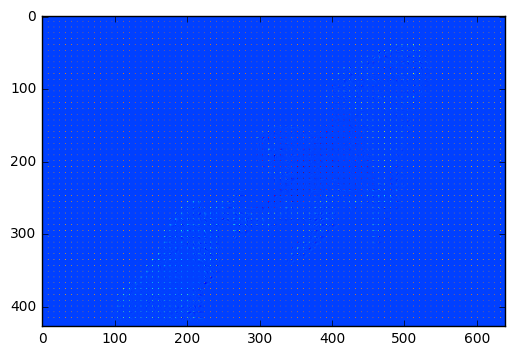

In [103]:
from scipy.fftpack import dct

block_size = 8
Y_dct = np.zeros((y_height, y_width))

for y in range(0,y_height - (block_size-1), block_size):
    yRange = np.arange(y,y+block_size)
    for x in range(0, y_width - (block_size-1), block_size):
        xRange = np.arange(x,x+block_size)
        Y_dct[np.ix_(yRange,xRange)] = dct(dct(Y[np.ix_(yRange,xRange)].T, norm='ortho').T, norm='ortho')

plt.imshow(Y_dct);

## Back to the Pixel Domain

To make sure we don't have any errors, let's perform the inverse dct on each 8x8 block.

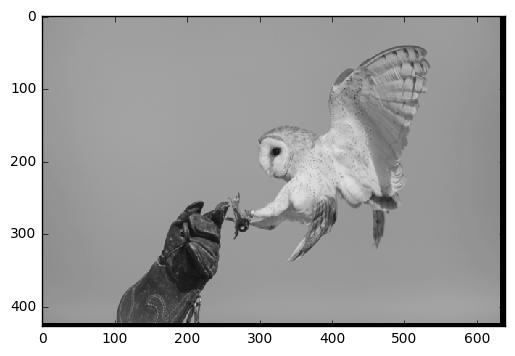

In [98]:
from scipy.fftpack import idct

block_size = 8
Y_idct = np.zeros((y_height, y_width))

for y in range(0,y_height - block_size, block_size):
    yRange = np.arange(y,y+block_size)
    for x in range(0, y_width - block_size, block_size):
        xRange = np.arange(x,x+block_size)
        Y_idct[np.ix_(yRange,xRange)] = idct(idct(Y_dct[np.ix_(yRange,xRange)].T, norm='ortho').T, norm='ortho')

plt.imshow(Y_idct, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255, aspect='equal', interpolation='nearest');

## Subsampling Time

To subsample our image in the frequency domain, one simple trick is only to take the coefficients starting from the top left. In this case, since we want a quarter of the image size, we take the top left 4x4 block.

Notice that When we perform the inverse transform on the 4x4 block N (in the previous equations) is now 16 (instead of 64, when we had 8x8 blocks). As can be seen in the following images the coefficient are scaled for a 8x8 dct not for a 4x4. To fix this, we divide the values by 2.

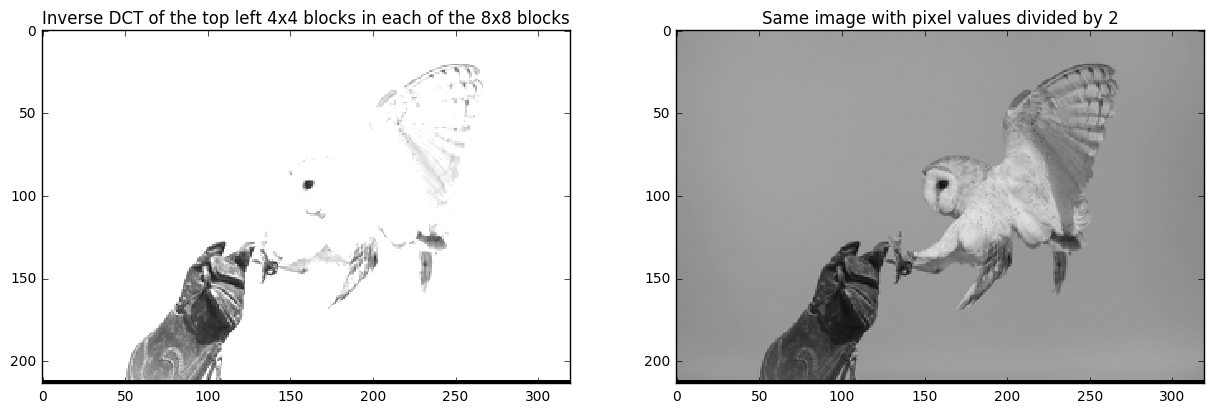

In [117]:
## DCT Subsampling

from scipy.fftpack import idct

sub_block_size = 4
y_sub_height = y_height // 2
y_sub_width = y_width // 2
Y_sub = np.zeros((y_sub_height, y_sub_width))

yy = 0
for y in range(0,y_sub_height - (sub_block_size-1), sub_block_size):
    y_sub_range = range(y,y+sub_block_size)
    y_range = range(yy,yy+sub_block_size)
    
    xx = 0
    for x in range(0, y_sub_width - (sub_block_size-1), sub_block_size):
        x_sub_range = range(x,x+sub_block_size)
        x_range = range(xx, xx+sub_block_size)
        Y_sub[np.ix_(y_sub_range, x_sub_range)] = idct(idct(Y_dct[np.ix_(y_range, x_range)].T, norm='ortho').T, norm='ortho')
        
        xx = xx + block_size
    
    yy = yy + block_size
    
Y_sub_scaled = Y_sub // 2;

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Inverse DCT of the top left 4x4 blocks in each of the 8x8 blocks')
plt.imshow(Y_sub, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255, aspect='equal', interpolation='nearest');
plt.subplot(1,2,2)
plt.title('Same image with pixel values divided by 2')
plt.imshow(Y_sub_scaled, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255, aspect='equal', interpolation='nearest');

## Comparing with spatial domain subsampling

We can compare the results with a pixel domain subsampling. Looking at the owl, we notice that the DCT domain subsampling is blurrier. This is not necessarily a bad thing, looking back at the Cb and Cr planes in the first image, these planes don't have the sharp details of the luma plane, so a blurred prediction is ideal

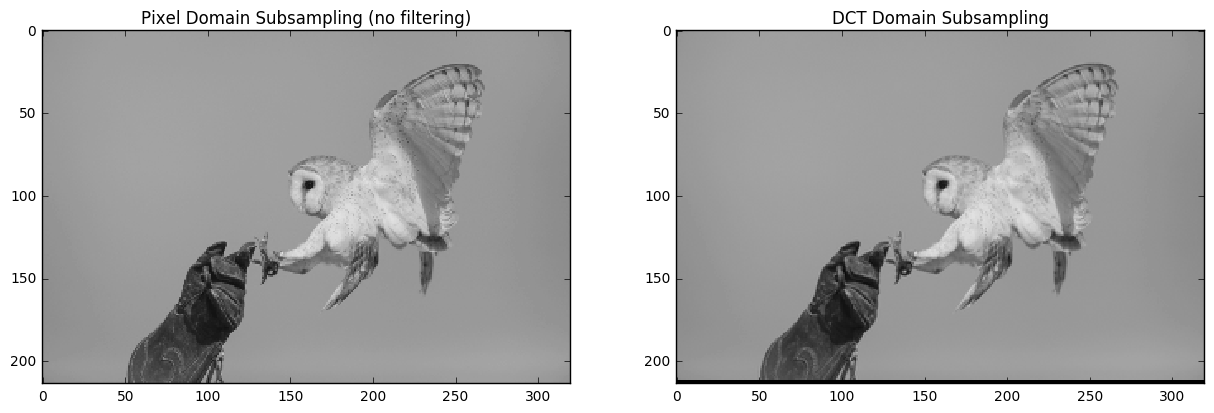

In [106]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Pixel Domain Subsampling (no filtering)')
plt.imshow(Y[::2, ::2], cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255, aspect='equal', interpolation='nearest');
plt.subplot(1,2,2)
plt.title('DCT Domain Subsampling')
plt.imshow(Y_sub_scaled, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255, aspect='equal', interpolation='nearest');